In [1]:
#| hide
!pip install -Uqq nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.8 MB/s eta 0:00:00


In [2]:
#| hide
from nixtla.utils import in_colab

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
#| hide
IN_COLAB = in_colab()

In [4]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

In [5]:
#| echo: false
if not IN_COLAB:
    load_dotenv()

In [6]:
import pandas as pd
from nixtla import NixtlaClient

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

In [9]:
%cd drive/MyDrive/Colab\ Notebooks
!pip install python-dotenv

/content/drive/MyDrive/Colab Notebooks


In [10]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [11]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = os.environ.get("MY_NIXTLA_API_KEY")
)

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [13]:
df.groupby('unique_id').head(2)

,unique_id,ds,y
0,AP-AP,2023-10-01 04:00:00+00:00,4042.513
1,AP-AP,2023-10-01 05:00:00+00:00,3850.067
8784,DOM-DOM,2023-10-01 04:00:00+00:00,10732.435
8785,DOM-DOM,2023-10-01 05:00:00+00:00,10314.211
17568,JC-JC,2023-10-01 04:00:00+00:00,1825.101
17569,JC-JC,2023-10-01 05:00:00+00:00,1729.590
26352,PN-PN,2023-10-01 04:00:00+00:00,1454.666
26353,PN-PN,2023-10-01 05:00:00+00:00,1416.688
35136,RTO-RTO,2023-10-01 04:00:00+00:00,69139.393
35137,RTO-RTO,2023-10-01 05:00:00+00:00,66207.416


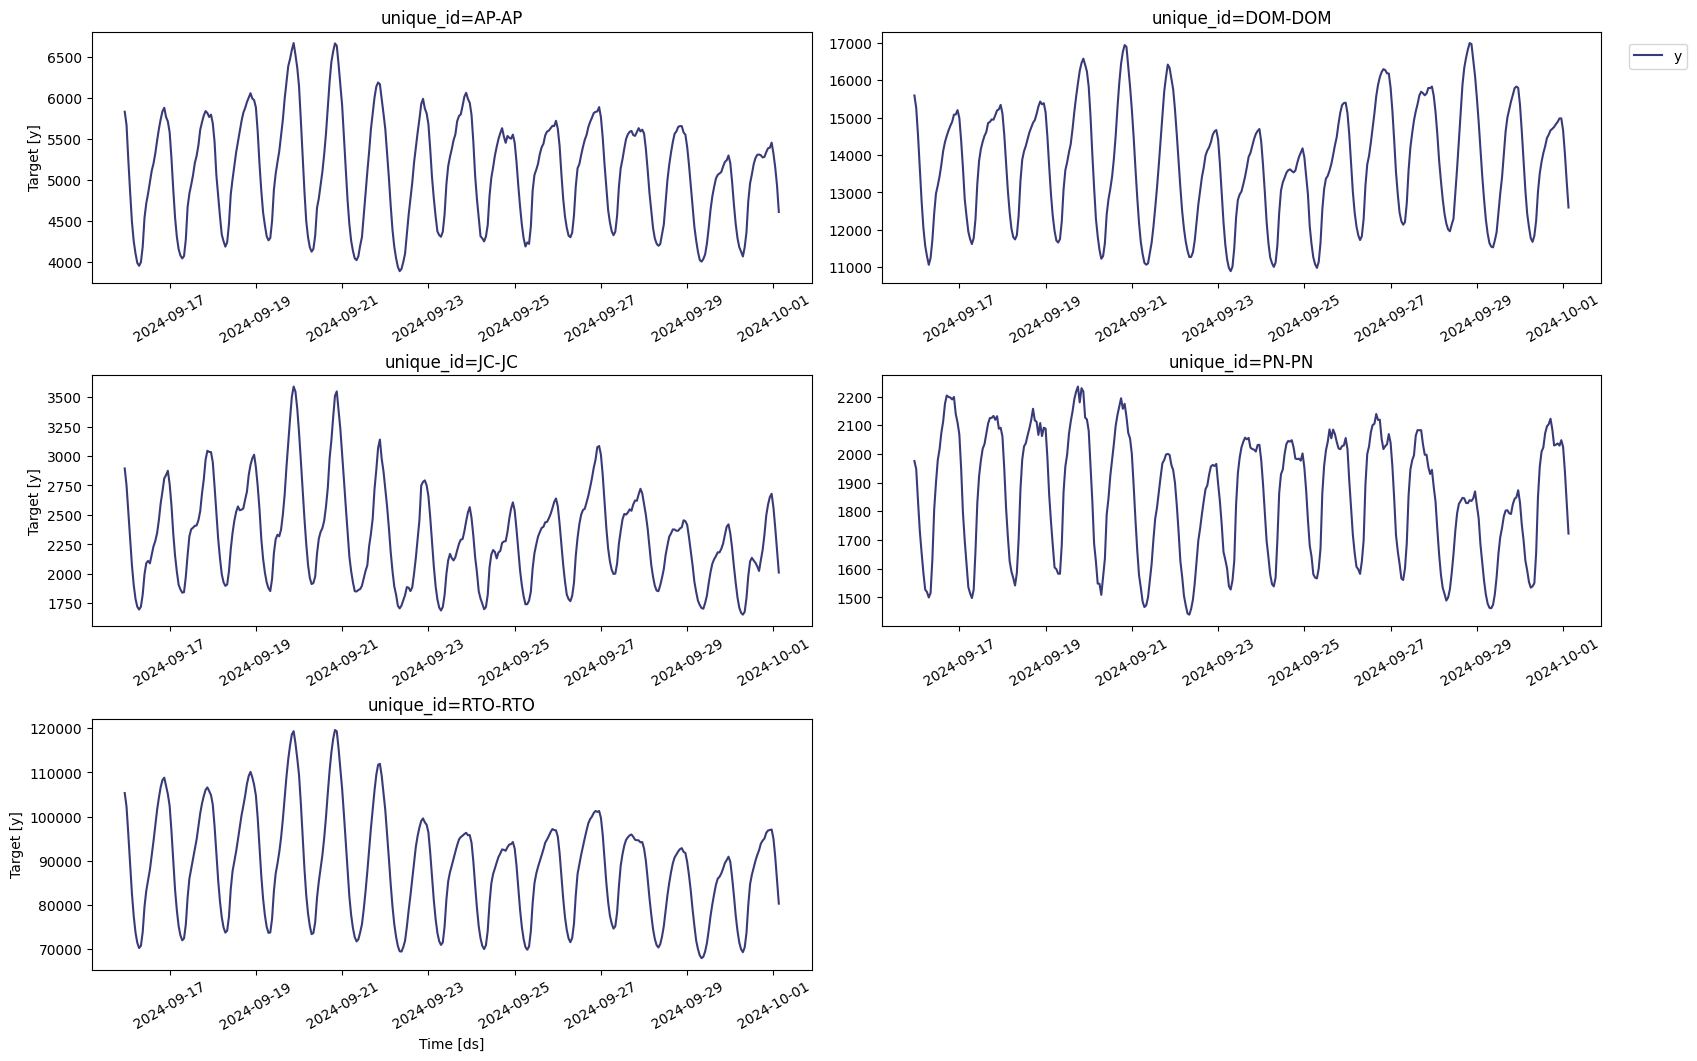

In [14]:
nixtla_client.plot(
    df,
    max_insample_length=365,
)

In [15]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 4 days (96 *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)

<ipython-input-15-1c474d0b2206>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)


In [17]:
import time
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 4.185089349746704


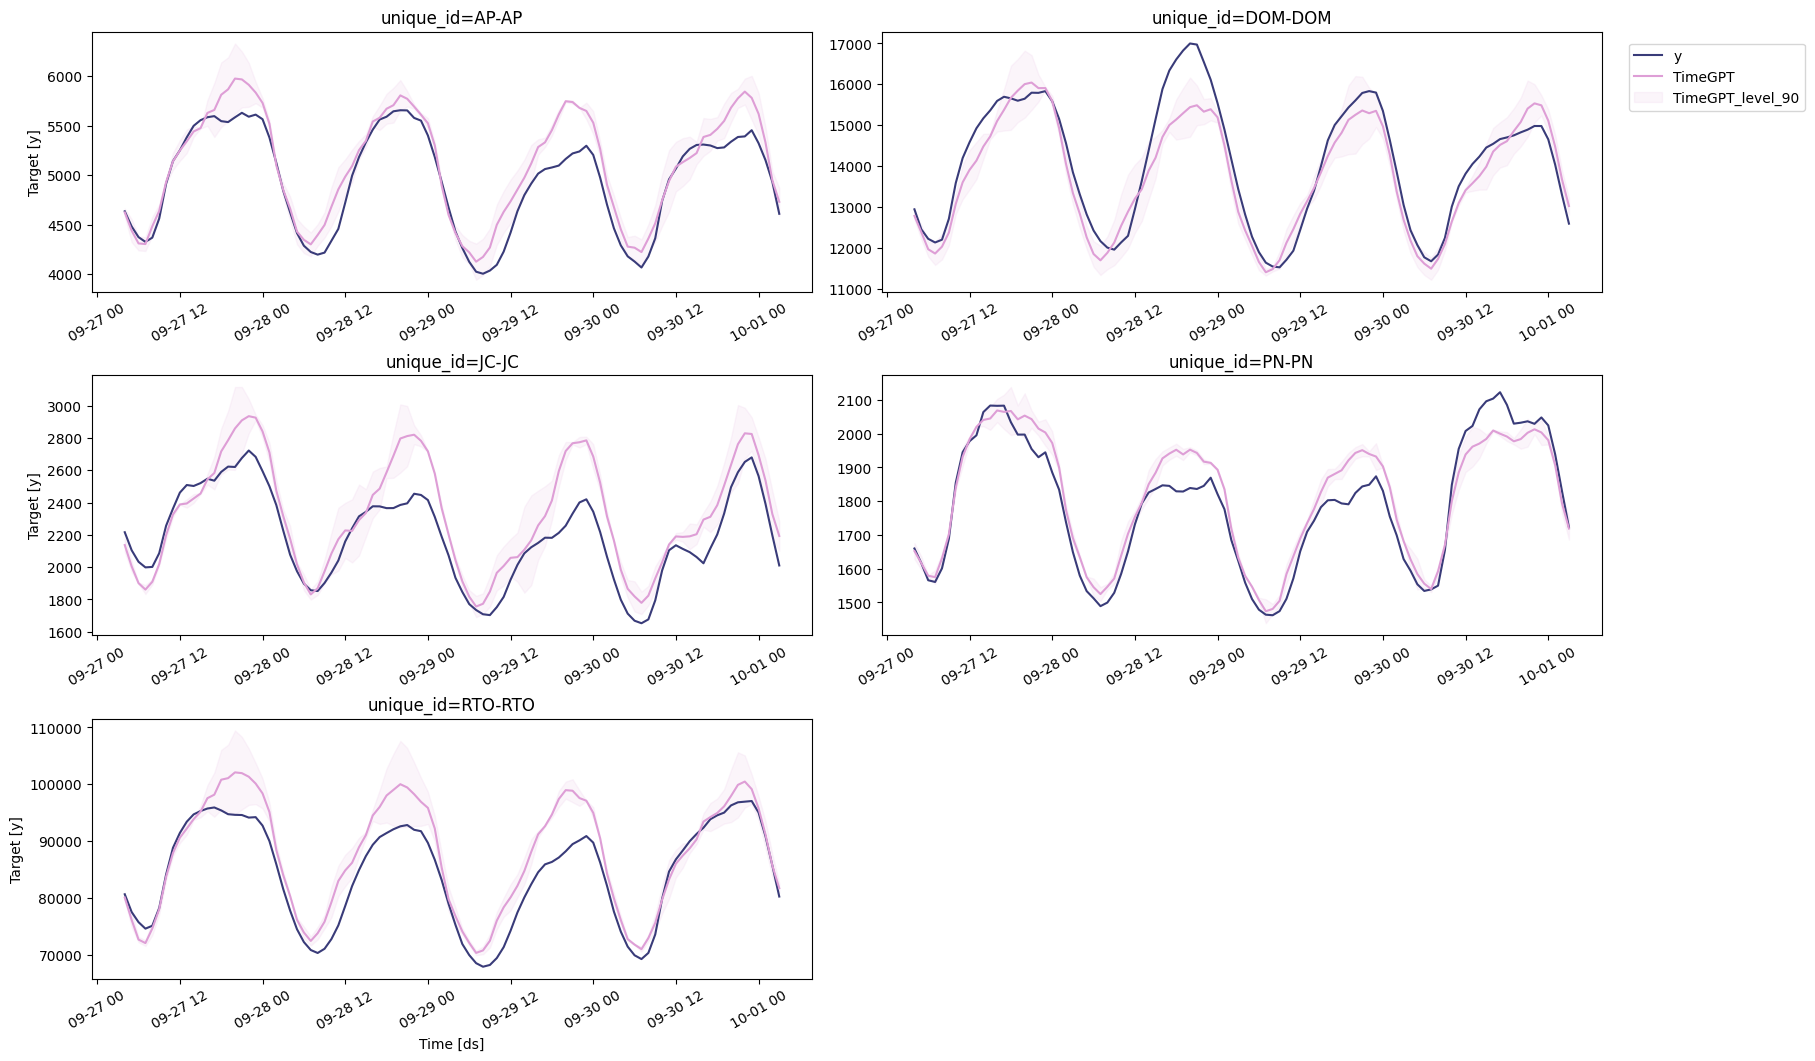

In [18]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [19]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [23]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

,TimeGPT
metric,
mae,882.523468
smape,0.019971


In [24]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [25]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

In [26]:
train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-96]).reset_index(drop=True)

<ipython-input-26-d11dc2a3209f>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-96]).reset_index(drop=True)


In [27]:
horizon = 96

models = [NHITS(h=horizon, input_size = 5*horizon, scaler_type='robust', batch_size=16, valid_batch_size=8)]

nf = NeuralForecast(models=models, freq='H')

start = time.time()

nf.fit(df=train_df)
nhits_preds = nf.predict()

end = time.time()

nhits_duration = end - start

print(f"Time (N-HiTS): {nhits_duration}")

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.727    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Time (N-HiTS): 1196.4421982765198


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [28]:
preds_df = pd.merge(test_df, nhits_preds, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    preds_df,
    metrics=[mae, smape],
    models=["NHITS"],
    target_col="y",
    id_col='unique_id'
)


average_metrics = evaluation.groupby('metric')['NHITS'].mean()
print(average_metrics)

metric
mae      961.645964
smape      0.028194
Name: NHITS, dtype: float64
